In [1]:
import pandas as pd 
import numpy as np 
import numpy.linalg as la
import openpyxl

import urllib
import ssl
import json
import sys
import matplotlib

#### User Cost Framework
UC=r+τ+m+ρ-mt(r+τ)-π^e
- ***Foregone Interest (r):*** The opportunity cost of tying up capital in housing rather than investing it elsewhere.
- ***Property Taxes (τ):*** Includes stamp duties and other government-imposed costs associated with property ownership.
- ***Maintenance Costs (m):*** Expenses incurred for maintaining and preserving the quality of the property.
  - https://www.censtatd.gov.hk/en/web_table.html?id=520-63001#
  - Assumed to be fixed rate given by (median maintenance + management fee)/(median rental cost) 
- ***Risk Premium (ρ):*** Reflects the higher uncertainty and variability of returns in owning a property compared to renting. This can be calculated as the ex post annual house price return minus ex post annual rental changes.
- ***Marginal Tax (mt):*** Taxes directly levied on house buyers.
- ***Expected Capital Gain (π^e):*** Anticipated appreciation in property value. Traditional models simplistically assume fixed risk premiums and CPI-based capital gains, ignoring housing market dynamics. Realized house price returns better estimate capital gains, correcting for CPI's exclusion of housing costs and improving user cost accuracy  

Fundamental Price-to-Rent Ratio = P*/R = 1/User Cost
- P*: Theoretical (fundamental) house price.
- R: Actual market rent

Deviation between the real market P/R vs the theoretical P*/R indicates overvaluation or devaluation 
- Overvaluation: P/R > P*/R
- Undervaluation: P/R < P*/R

In [ ]:
# Set up correct SSL certificates for pulling data from HKMA API 
context = ssl._create_unverified_context()
loadingcomplete = False
data = []
url = 'https://api.hkma.gov.hk/public/market-data-and-statistics/monthly-statistical-bulletin/er-ir/hk-interbank-ir-daily?segment=hibor.fixing&pagesize=1000&fields=end_of_day,ir_1m&offset='
offset = 0

# Generates repeated queries to the HKMA API for ir_1m data by 1000 (maximum query limit) until end of query
while not loadingcomplete:
    req = urllib.request.urlopen(url + str(offset), context = context).read()
    req = req.decode('utf8').replace("'", '"')
    req = json.loads(req)

    data.append(req)
    
    if data[-1]['result']['datasize'] != 1000:
        loadingcomplete = True
    else:
        offset += 1000

temp = []

# Converts all output JSON files into dataframe format to be concatenated into one big dataframe
for i in range(len(data)):
    temp.append(pd.read_json(json.dumps(data[i]['result']['records'])))

df_ir = pd.concat(temp, ignore_index=True)
# df_ir.to_excel("HK IR 1m.xlsx", index=False)

C:\Users\aweso\AppData\Local\Temp\ipykernel_13548\2530066268.py:25: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  temp.append(pd.read_json(json.dumps(data[i]['result']['records'])))
C:\Users\aweso\AppData\Local\Temp\ipykernel_13548\2530066268.py:25: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  temp.append(pd.read_json(json.dumps(data[i]['result']['records'])))
C:\Users\aweso\AppData\Local\Temp\ipykernel_13548\2530066268.py:25: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  temp.append(pd.read_json(json.dumps(data[i]['result']['records'])))
C:\Users\aweso\AppData\Local\Temp\ipykernel_13548\2530066268.py:25: FutureWarni

In [3]:
# df_user_cost['Log_HPI'] = np.log(df_user_cost['HPI'])
# df_user_cost['Log_Rent'] = np.log(df_user_cost['HRI'])
# df_user_cost['Log_Ratio'] = np.log(df_user_cost['HPI/HRI'])
# df_user_cost['Log_Ratio_Fundamental'] = np.log(df_user_cost['1/UC (HPIf/HRI)'])

In [4]:
'''
Data has been preprocessed and stored in data.xlsx

Sources:
- Foregone Interest (r): HIBOR 1m, obtained through HKMA API above
- Property Taxes (τ): 15% on rateable value of property, with 20% deducted for expenses 
  - E.g., If rent is 0.5% of the property value, tax would be 80% of (0.5%*15%)
  - Stamp duty is assumed to be negligble 
- Maintenance Costs (m): Expenses incurred for maintaining and preserving the quality of the property.
  - https://www.censtatd.gov.hk/en/web_table.html?id=520-63001#
  - Assumed to be fixed rate given by (median maintenance + management fee)/(median rental cost) 
- Risk Premium (ρ): HK Govt Data
- Marginal Tax (mt): HK Govt Data
- Expected Capital Gain (π^e): Gap between rental yield and risk premium

ph_t = c_1*pr_t^f + c_2*hri_t + b_t + c_3

Where:
ph_t = Log Housing Price
pr_t^f = Log(1/UC_t) (Log Fundamental Price-Rent Ratio) 
hri_t = Log Rent 
b_t = Log Bubble

State Equation 
b_t = (1/c_4)*b_t-1 + c_5
b_'0 = 0

Where
c_3 = i.i.d. N(0,R)
c_5 = i.i.d. N(0,V)
E(c_3,c_5) = 0, E(c_3,b'_0) = 0, E(c_5,b'_0) = 0

When 0 < c_4 < 1 indicates a explosive path for the bubble 


'''

"\nData has been preprocessed and stored in data.xlsx\n\nSources:\n- Foregone Interest (r): HIBOR 1m, obtained through HKMA API above\n- Property Taxes (τ): 15% on rateable value of property, with 20% deducted for expenses \n  - E.g., If rent is 0.5% of the property value, tax would be 80% of (0.5%*15%)\n  - Stamp duty is assumed to be negligble \n- Maintenance Costs (m): Expenses incurred for maintaining and preserving the quality of the property.\n  - https://www.censtatd.gov.hk/en/web_table.html?id=520-63001#\n  - Assumed to be fixed rate given by (median maintenance + management fee)/(median rental cost) \n- Risk Premium (ρ): HK Govt Data\n- Marginal Tax (mt): HK Govt Data\n- Expected Capital Gain (π^e): Gap between rental yield and risk premium\n\nph_t = c_1*pr_t^f + c_2*hri_t + b_t + c_3\n\nWhere:\nph_t = Log Housing Price\npr_t^f = Log(1/UC_t) (Log Fundamental Price-Rent Ratio) \nhri_t = Log Rent \nb_t = Log Bubble\n\nState Equation \nb_t = (1/c_4)*b_t-1 + c_5\nb_'0 = 0\n\nWhere

In [14]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import scipy.stats

# Load data
df_user_cost = pd.read_excel("User Cost.xlsx")
df_user_cost['Price'] = df_user_cost['HPI']
df_user_cost['Rent'] = df_user_cost['HRI']
df_user_cost['Price_Fundamental'] = df_user_cost['1/UC (HPIf/HRI)']*df_user_cost['HRI']
# df_user_cost['Log_HPI'] = np.log(df_user_cost['HPI'])
# df_user_cost['Log_Rent'] = np.log(df_user_cost['HRI'])
# df_user_cost['Log_Price_Fundamental'] = np.log(df_user_cost['1/UC (HPIf/HRI)']*df_user_cost['HRI'])
# Observations
ph_t = df_user_cost['Price'].values
pr_t_f = df_user_cost['Price_Fundamental'].values
hri_t = df_user_cost['Rent'].values

# Kalman Filter Implementation
def kalman_filter(params):
    c1, c2, c4, R, V = params
    n = len(ph_t)
    
    # State and observation matrices
    F = np.array([[1 / c4]])  # State transition matrix
    H = np.array([[c1, c2, 1]])  # Observation matrix
    Q = np.array([[V]])  # Process noise covariance
    R = np.array([[R]])  # Measurement noise covariance
    
    # Initial state and covariance
    b_t = np.zeros((1, 1))  # Initial state (log bubble)
    P = np.eye(1)  # Initial state covariance
    
    log_likelihood = 0
    
    for t in range(n):
        # Observation vector
        z_t = np.array([[ph_t[t] - c1 * pr_t_f[t] - c2 * hri_t[t]]])
        
        # Prediction step
        b_t_pred = np.dot(F, b_t)
        P_pred = np.dot(F, np.dot(P, F.T)) + Q
        
        # Update step
        S_t = np.dot(H[:, 2:], np.dot(P_pred, H[:, 2:].T)) + R + 1e-3 * np.eye(R.shape[0])  # Regularization
        K_t = np.dot(P_pred, np.dot(H[:, 2:].T, np.linalg.inv(S_t)))  # Kalman gain
        y_t = z_t - np.dot(H[:, 2:], b_t_pred)  # Innovation
        b_t = b_t_pred + np.dot(K_t, y_t)
        P = np.dot(np.eye(1) - np.dot(K_t, H[:, 2:]), P_pred)
        
        # Log-likelihood
        log_likelihood += -0.5 * (np.log(np.linalg.det(S_t)) + np.dot(y_t.T, np.dot(np.linalg.inv(S_t), y_t)))

    return -log_likelihood[0, 0]  # Negative log-likelihood for minimization

# Objective function for optimization
def objective_function(params):
    return kalman_filter(params)

# Initial guesses for parameters
initial_params = [0, 0, 0.5, 0, 0]  # Based on linreg

# Minimize negative log-likelihood
# result = minimize(objective_function, initial_params, bounds=[(None, None), (None, None), (0, 1), (1e-6, None), (1e-6, None)])
result = minimize(objective_function, initial_params, bounds=[(None, None), (None, None), (None, None), (1e-6, None), (1e-6, None)])


# Extract estimated parameters
c1_est, c2_est, c4_est, R_est, V_est = result.x

# Compute standard errors (Hessian approximation)
hessian_inv = result.hess_inv.todense()  # Inverse Hessian matrix
standard_errors = np.sqrt(np.diag(hessian_inv))  # Standard errors

# Compute statistical significance (t-stats and p-values)
t_stats = result.x / standard_errors
p_values = 2 * (1 - scipy.stats.norm.cdf(np.abs(t_stats)))

# Compute AIC
log_likelihood = -result.fun
k = len(initial_params)  # Number of parameters
aic = 2 * k - 2 * log_likelihood

# Output results
print(f"Estimated Parameters:\nc1: {c1_est}\nc2: {c2_est}\nc4: {c4_est}\nR: {R_est}\nV: {V_est}")
print(f"Standard Errors: {standard_errors}")
print(f"T-Statistics: {t_stats}")
print(f"P-Values: {p_values}")
print(f"AIC: {aic}")
print(f"Log-Likelihood: {log_likelihood}")

Estimated Parameters:
c1: 0.0014022568987297017
c2: 0.946018857917871
c4: 0.9993952080190207
R: 1e-06
V: 14.749394315297094
Standard Errors: [ 0.067381    1.72917983  0.10006423  1.         59.26620818]
T-Statistics: [2.08108646e-02 5.47091080e-01 9.98753659e+00 1.00000000e-06
 2.48866846e-01]
P-Values: [0.98339653 0.58431616 0.         0.9999992  0.80346378]
AIC: 1279.8071744797314
Log-Likelihood: -634.9035872398657


In [ ]:
# # Compute correlation matrix
# df_user_cost['Log_Price_Fundamental'] = np.log(df_user_cost['1/UC (HPIf/HRI)']*df_user_cost['HRI'])
# df_user_cost['Log_Ratio_Fundamental'] = np.log(df_user_cost['1/UC (HPIf/HRI)'])
# correlation_matrix = df_user_cost[['Log_HPI', 'Log_Rent', 'Log_Ratio_Fundamental','Log_Price_Fundamental']].corr()
# correlation_matrix = df_user_cost[['Log_HPI', 'Log_Rent', 'Log_Price_Fundamental']].corr()
# print("Correlation Matrix:")
# print(correlation_matrix)

Correlation Matrix:
                        Log_HPI  Log_Rent  Log_Price_Fundamental
Log_HPI                1.000000  0.981275               0.523297
Log_Rent               0.981275  1.000000               0.450281
Log_Price_Fundamental  0.523297  0.450281               1.000000


In [7]:
for i in t_stats:
    print(i)

0.00265085469813085
0.01956727505125879
0.7003840380452369
1e-06
0.019138250088851224


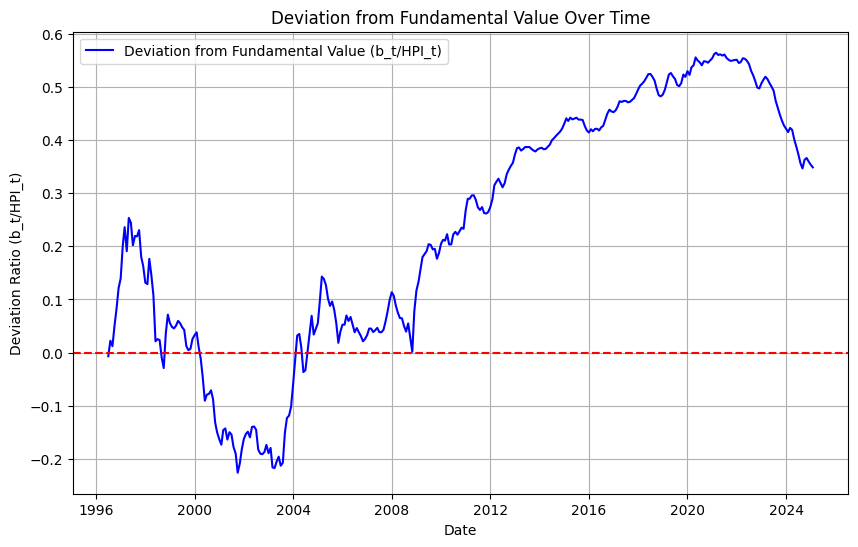

In [16]:
import matplotlib.pyplot as plt

# ph_t = c_1*pr_t^f + c_2*hri_t + b_t + c_3

# b_t = np.exp(df_user_cost['Log_HPI'] - c1_est * df_user_cost['Log_Ratio_Fundamental'] - c2_est * df_user_cost['Log_Rent'])
b_t = (df_user_cost['Price'] - c1_est * df_user_cost['Price_Fundamental'] - c2_est * df_user_cost['Rent'])/df_user_cost['Price']

# Plot the deviation
plt.figure(figsize=(10, 6))
plt.plot(df_user_cost['Dates'], b_t, label='Deviation from Fundamental Value (b_t/HPI_t)', color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Deviation Ratio (b_t/HPI_t)')
plt.title('Deviation from Fundamental Value Over Time')
plt.legend()
plt.grid()
plt.show()

Linreg OLS

                            OLS Regression Results                            
Dep. Variable:                Log_HPI   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     5758.
Date:                Tue, 06 May 2025   Prob (F-statistic):          1.66e-263
Time:                        01:46:48   Log-Likelihood:                 291.91
No. Observations:                 344   AIC:                            -577.8
Df Residuals:                     341   BIC:                            -566.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -5.00

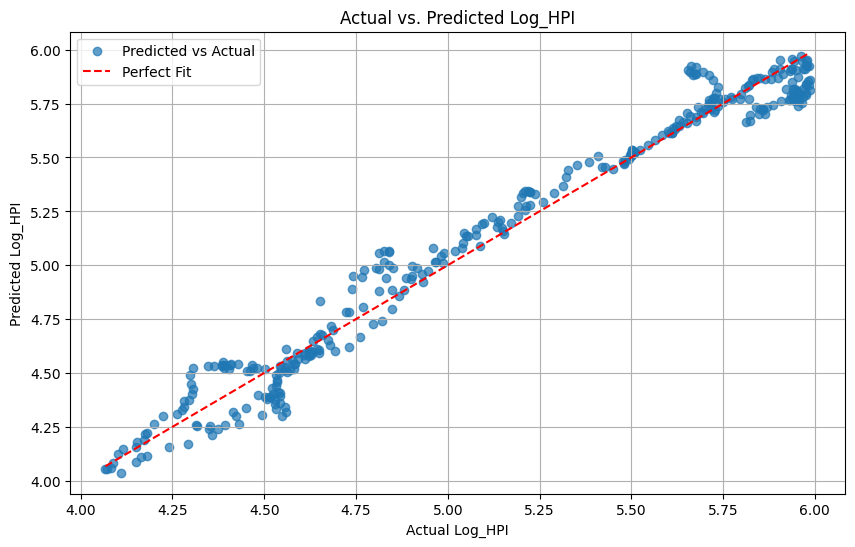

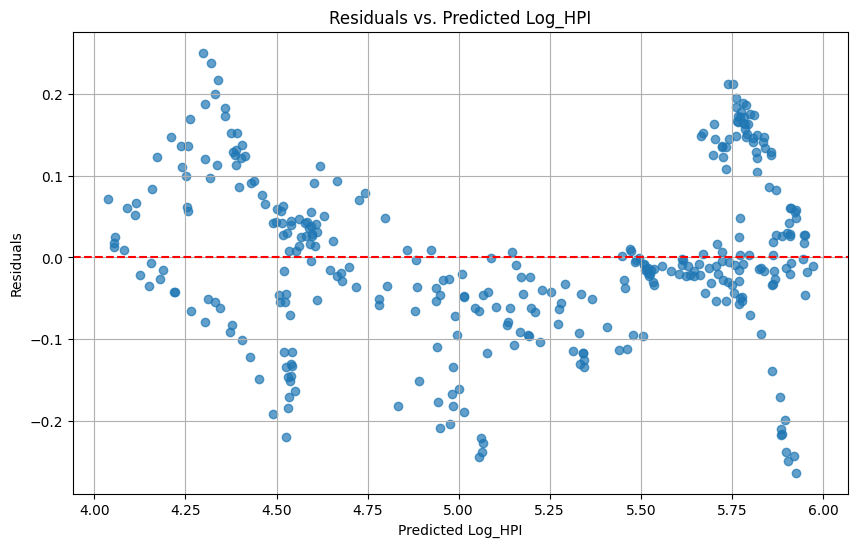

In [28]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load data
df_user_cost = pd.read_excel("User Cost.xlsx")
df_user_cost['Log_HPI'] = np.log(df_user_cost['HPI'])
df_user_cost['Log_Rent'] = np.log(df_user_cost['HRI'])
df_user_cost['Log_Ratio_Fundamental'] = np.log(df_user_cost['1/UC (HPIf/HRI)'])

# Define dependent and independent variables
# Dependent variable: Log_HPI (log of housing price index)
# Independent variables: Log_Ratio_Fundamental and Log_Rent
X = df_user_cost[['Log_Ratio_Fundamental', 'Log_Rent']]
y = df_user_cost['Log_HPI']

# Add a constant to the independent variables (for the intercept)
X = sm.add_constant(X)

# Perform linear regression
model = sm.OLS(y, X).fit()

# Print regression results
print(model.summary())

# Predicted values
df_user_cost['Predicted_Log_HPI'] = model.predict(X)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(df_user_cost['Log_HPI'], df_user_cost['Predicted_Log_HPI'], alpha=0.7, label='Predicted vs Actual')
plt.plot([df_user_cost['Log_HPI'].min(), df_user_cost['Log_HPI'].max()],
         [df_user_cost['Log_HPI'].min(), df_user_cost['Log_HPI'].max()],
         color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual Log_HPI')
plt.ylabel('Predicted Log_HPI')
plt.title('Actual vs. Predicted Log_HPI')
plt.legend()
plt.grid()
plt.show()

# Plot residuals
df_user_cost['Residuals'] = df_user_cost['Log_HPI'] - df_user_cost['Predicted_Log_HPI']
plt.figure(figsize=(10, 6))
plt.scatter(df_user_cost['Predicted_Log_HPI'], df_user_cost['Residuals'], alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Log_HPI')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Log_HPI')
plt.grid()
plt.show()

#### Macroeconomic Data
PH = PH(RDY, MR, RRI, C, PO, UN, TAX, CA)
- Real disposable income (RDY)
- Mortgage rates (MR)
- Real residential investment (RRI) 
- Credit volume (C)
- Population growth (PO)
- Unemployment (UN)
- Taxation (TAX)
- Current account balance (CA).

In [ ]:
'''
Data Pulling and Processing for Macreconomic Framework

Sources:
https://apidocs.hkma.gov.hk/documentation/market-data-and-statistics/monthly-statistical-bulletin/banking/residential-mortgage-survey/
 
'''
# Set up correct SSL certificates for pulling data from HKMA API 
context = ssl._create_unverified_context()
loadingcomplete = False
data = []
url = 'https://api.hkma.gov.hk/public/market-data-and-statistics/monthly-statistical-bulletin/banking/residential-mortgage-survey?segment=new&fields=end_of_month,outstanding_loans_amt&pagesize=1000&offset='
offset = 0

# Generates repeated queries to the HKMA API data by 1000 (maximum query limit) until end of query
while not loadingcomplete:
    req = urllib.request.urlopen(url + str(offset), context = context).read()
    req = req.decode('utf8').replace("'", '"')
    req = json.loads(req)

    data.append(req)
    
    if data[-1]['result']['datasize'] != 1000:
        loadingcomplete = True
    else:
        offset += 1000

temp = []

# Converts all output JSON files into dataframe format to be concatenated into one big dataframe
for i in range(len(data)):
    temp.append(pd.read_json(json.dumps(data[i]['result']['records'])))

df_domestic_credit = pd.concat(temp, ignore_index=True)

loadingcomplete = False
url = 'https://api.hkma.gov.hk/public/market-data-and-statistics/monthly-statistical-bulletin/banking/residential-mortgage-survey?segment=old&fields=end_of_month,outstanding_loans_amt&pagesize=1000&offset='
offset = 0

while not loadingcomplete:
    req = urllib.request.urlopen(url + str(offset), context = context).read()
    req = req.decode('utf8').replace("'", '"')
    req = json.loads(req)

    data.append(req)
    
    if data[-1]['result']['datasize'] != 1000:
        loadingcomplete = True
    else:
        offset += 1000

temp = []

# Converts all output JSON files into dataframe format to be concatenated into one big dataframe
for i in range(len(data)):
    temp.append(pd.read_json(json.dumps(data[i]['result']['records'])))

df_domestic_credit = pd.concat(temp, ignore_index=True)
# df_domestic_credit.to_excel("Domestic Credit.xlsx", index=False)

C:\Users\aweso\AppData\Local\Temp\ipykernel_22420\1720599019.py:32: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  temp.append(pd.read_json(json.dumps(data[i]['result']['records'])))
C:\Users\aweso\AppData\Local\Temp\ipykernel_22420\1720599019.py:56: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  temp.append(pd.read_json(json.dumps(data[i]['result']['records'])))
C:\Users\aweso\AppData\Local\Temp\ipykernel_22420\1720599019.py:56: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  temp.append(pd.read_json(json.dumps(data[i]['result']['records'])))


In [ ]:
df_pca = pd.read_excel("PCA.xlsx")

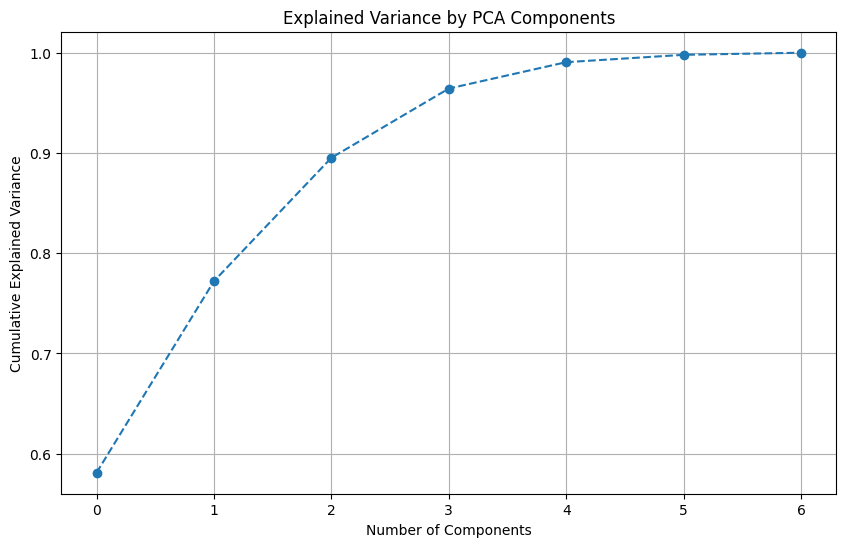

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Drop rows with missing values
df_pca_cleaned = df_pca.dropna()

# Select features for PCA (excluding 'Dates' and 'HPI')
features = ['Real Disposable Income (HK $m)', 'Mortgage Rates', 'Credit Volume (HK $m)', 
            'Population Growth*', 'Unemployment', 'Direct Taxation (to GDP)', 
            'Current Account Balance (HK $m)']

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(df_pca_cleaned[features])

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_ratio), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid()
plt.show()

# Add PCA components to the dataframe
for i in range(X_pca.shape[1]):
    df_pca_cleaned[f'PCA_Component_{i+1}'] = X_pca[:, i]

# Display the first few rows of the dataframe with PCA components
# print(df_pca_cleaned[['HPI'] + [f'PCA_Component_{i+1}' for i in range(X_pca.shape[1])]].head())

In [ ]:
# Extract eigenvalues from explained variance
eigenvalues = pca.explained_variance_

# Calculate the difference between consecutive eigenvalues
differences = np.diff(eigenvalues, prepend=0)

# Calculate the proportion of variance explained by each component
proportions = explained_variance_ratio

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(proportions)

# Create a DataFrame to display the results
pca_summary = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(len(eigenvalues))],
    'Eigenvalue': eigenvalues,
    'Difference': differences,
    'Proportion': proportions,
    'Cumulative Variance': cumulative_variance
})

# Display the PCA summary
print(pca_summary)

# Eigenvectors of each variable
eigenvectors = pd.DataFrame(pca.components_, columns=features, index=[f'PC{i+1}' for i in range(len(pca.components_))])

# Display the eigenvectors
print("Eigenvectors:")
eigenvectors.T

  Component  Eigenvalue  Difference  Proportion  Cumulative Variance
0       PC1    4.079726    4.079726    0.580950             0.580950
1       PC2    1.341845   -2.737881    0.191078             0.772028
2       PC3    0.864659   -0.477187    0.123127             0.895155
3       PC4    0.485186   -0.379473    0.069090             0.964245
4       PC5    0.184906   -0.300280    0.026330             0.990575
5       PC6    0.051468   -0.133437    0.007329             0.997904
6       PC7    0.014718   -0.036750    0.002096             1.000000


Ordinary PCA Summary:

Eigenvalues by Component:
  PC1: 4.0797
  PC2: 1.3418
  PC3: 0.8647
  PC4: 0.4852
  PC5: 0.1849
  PC6: 0.0515
  PC7: 0.0147

Explained Variance Ratios by Component:
  PC1: 0.5809
  PC2: 0.1911
  PC3: 0.1231
  PC4: 0.0691
  PC5: 0.0263
  PC6: 0.0073
  PC7: 0.0021

Cumulative Explained Variance by Component:
  PC1: 0.5809
  PC2: 0.7720
  PC3: 0.8952
  PC4: 0.9642
  PC5: 0.9906
  PC6: 0.9979
  PC7: 1.0000

Loadings (Eigenvectors) for Each Feature:
                                      PC1       PC2       PC3       PC4  \
Real Disposable Income (HK $m)   0.482219  0.107378  0.009920 -0.057289   
Mortgage Rates                  -0.170853  0.645934 -0.578328  0.076844   
Credit Volume (HK $m)            0.432797  0.246194  0.062644 -0.496330   
Population Growth*               0.478607  0.001910 -0.030240 -0.343693   
Unemployment                    -0.355394  0.132469  0.662907 -0.292104   
Direct Taxation (to GDP)         0.392216 -0.328071  0.061410  0.554557   
Cur

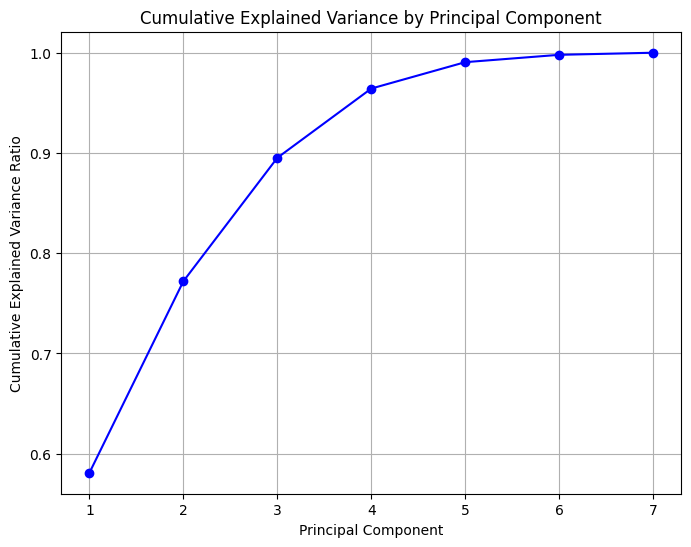

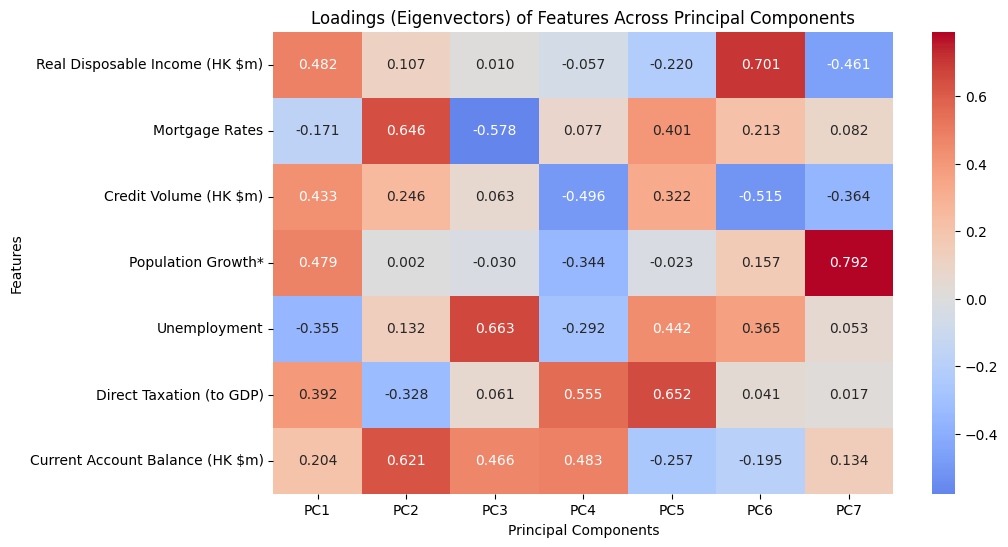

In [43]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from pykalman import KalmanFilter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns 

# Load and preprocess the data
df_pca = pd.read_excel("PCA.xlsx")  # Replace with your actual data file
df_pca_cleaned = df_pca.dropna()  # Drop rows with missing values

# Select features for PCA
features = ['Real Disposable Income (HK $m)', 'Mortgage Rates', 'Credit Volume (HK $m)', 
            'Population Growth*', 'Unemployment', 'Direct Taxation (to GDP)', 
            'Current Account Balance (HK $m)']

# Ordinary PCA function
def ordinary_pca(df, features, target='Housing Price'):
    """
    Apply standard PCA to the features in df.
    Returns PC1 scores, explained variance ratio, and loadings.
    """
    # Extract features
    X = df[features].values
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply PCA
    pca = PCA(n_components=len(features))  # First PC
    pc_scores = pca.fit_transform(X_scaled)
    
    # Explained variance
    eigenvalues = pca.explained_variance_ 
    explained_variance_ratios = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance_ratios)
    
    # Loadings
    loadings = pca.components_
    
    return pc_scores, explained_variance_ratios, cumulative_explained_variance, eigenvalues, loadings


# Run PCA
pc_scores, explained_variance_ratios, cumulative_explained_variance, eigenvalues, loadings = ordinary_pca(df_pca_cleaned, features)

# Create loadings DataFrame
loadings_df = pd.DataFrame(
    loadings.T, 
    columns=[f'PC{i+1}' for i in range(len(features))], 
    index=features
)

# Print PCA Summary
print("Ordinary PCA Summary:")
print("\nEigenvalues by Component:")
for i, eig in enumerate(eigenvalues, 1):
    print(f"  PC{i}: {eig:.4f}")
print("\nExplained Variance Ratios by Component:")
for i, evr in enumerate(explained_variance_ratios, 1):
    print(f"  PC{i}: {evr:.4f}")
print("\nCumulative Explained Variance by Component:")
for i, cev in enumerate(cumulative_explained_variance, 1):
    print(f"  PC{i}: {cev:.4f}")
print("\nLoadings (Eigenvectors) for Each Feature:")
print(loadings_df)

# Plot 1: Cumulative Explained Variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(features) + 1), cumulative_explained_variance, marker='o', linestyle='-', color='b')
plt.title('Cumulative Explained Variance by Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.xticks(range(1, len(features) + 1))
plt.show()
plt.savefig('cumulative_explained_variance_plot.png')
plt.close()

# Plot 2: Heatmap of Loadings
plt.figure(figsize=(10, 6))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title('Loadings (Eigenvectors) of Features Across Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Features')
plt.show()
plt.savefig('loadings_heatmap.png')
plt.close()

In [78]:
df_pca_cleaned['Bubble'] = b_t[30:-2].reset_index(drop=True)

Average coefficient change per time step: 0.560982
Average Kalman gain (mean abs value): 0.216295
TVP-PCA-Bubble Summary:
Negative Log-Likelihood: 694.0092

Eigenvalues by Component:
  PC1: 4.0659
  PC2: 1.3495
  PC3: 0.8659
  PC4: 0.4880
  PC5: 0.1869

Explained Variance Ratios by Component:
  PC1: 0.5790
  PC2: 0.1922
  PC3: 0.1233
  PC4: 0.0695
  PC5: 0.0266

Cumulative Explained Variance by Component:
  PC1: 0.5790
  PC2: 0.7711
  PC3: 0.8944
  PC4: 0.9639
  PC5: 0.9905

PCA Loadings (Eigenvectors):
                                      PC1       PC2       PC3       PC4  \
Real Disposable Income (HK $m)   0.482929  0.107549  0.010837 -0.059021   
Mortgage Rates                  -0.166225  0.646795 -0.579775  0.075575   
Credit Volume (HK $m)            0.433922  0.243633  0.068161 -0.492001   
Population Growth*               0.479339  0.000700 -0.027067 -0.344086   
Unemployment                    -0.356035  0.133455  0.662268 -0.286414   
Direct Taxation (to GDP)         0.391152

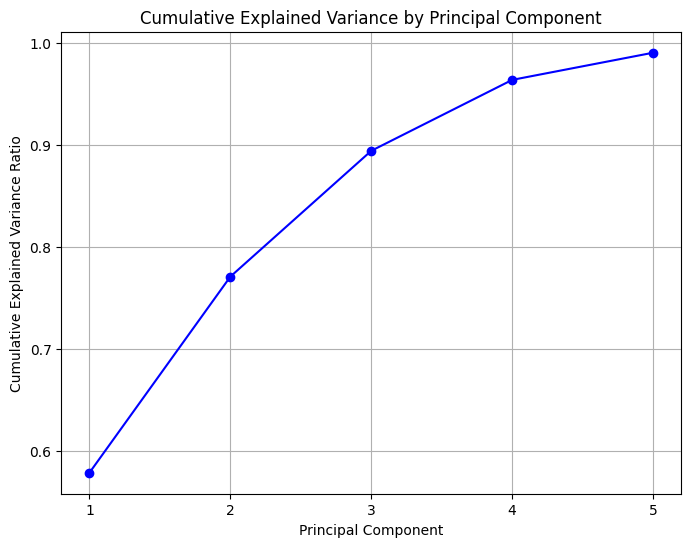

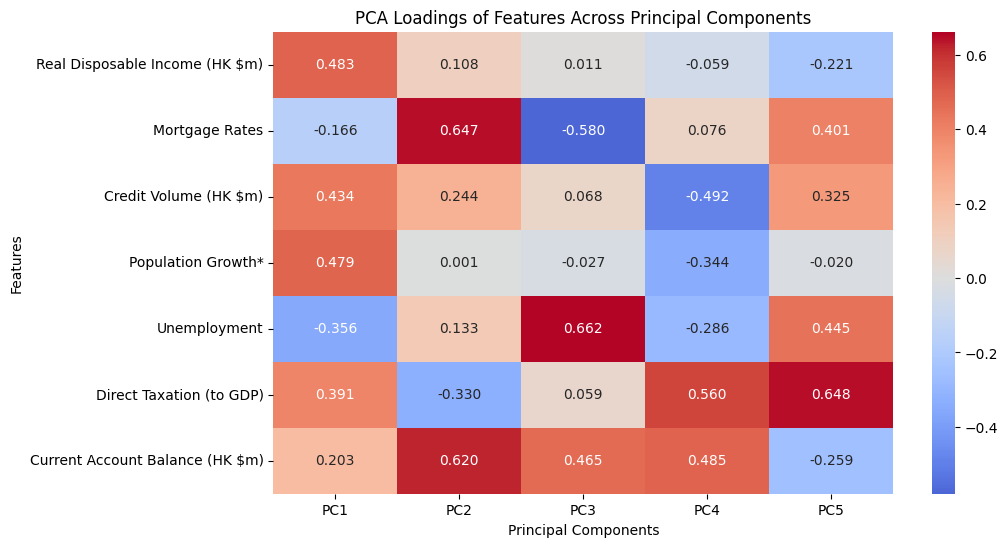

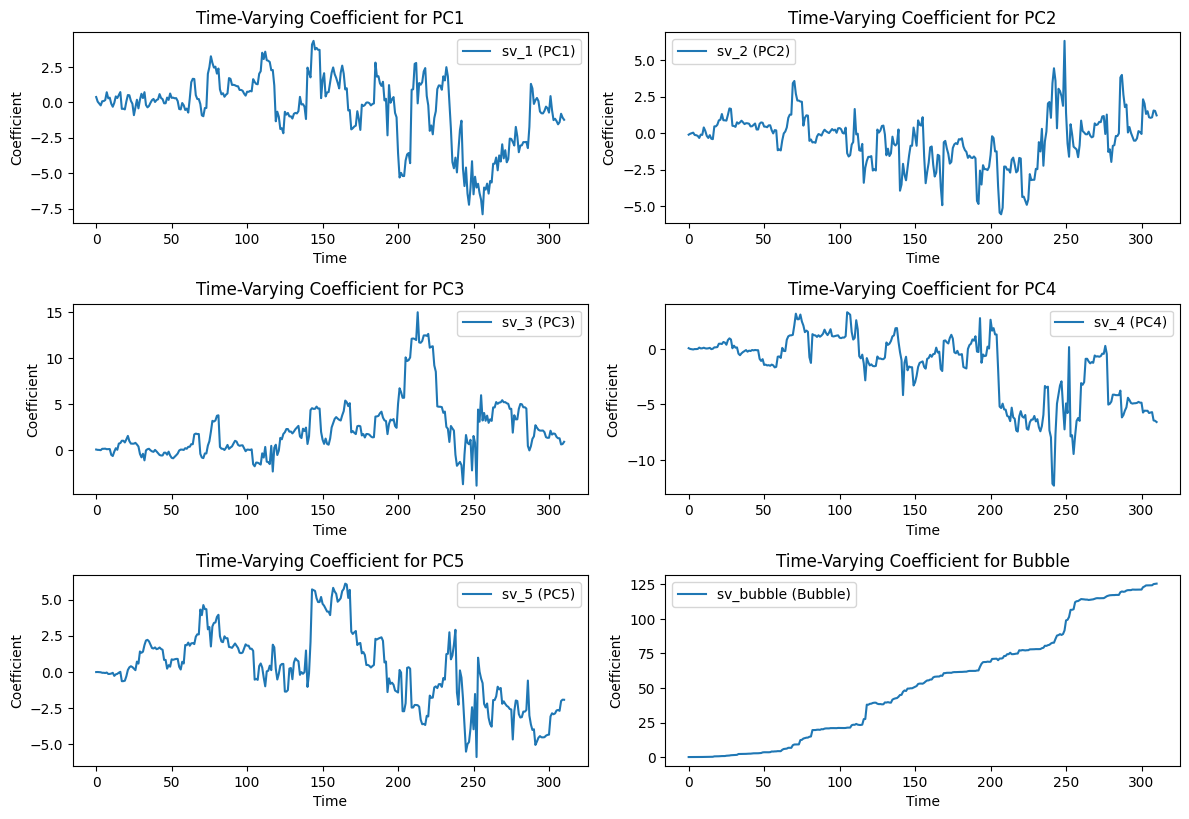

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# TVP-PCA-Bubble with Housing Price Change and Precomputed Bubble
def tvp_pca_bubble(df, features, params, n_components=5):
    """
    TVP-PCA-Bubble model with delta(housing price) as observation, using df['bubble'].
    params: [R, V] for noise variances
    n_components: Number of PCs (default: 5)
    Returns: PC scores, coefficients, explained variance, eigenvalues, and log-likelihood
    """
    R, V = params
    n = len(df)
    n_features = len(features)
    
    # Compute differences
    delta_housing = df['HPI'].diff().dropna()
    delta_bubble = df['Bubble'].diff().dropna()
    df = df.iloc[1:].copy()  # Align with differences
    delta_housing = delta_housing.values
    delta_bubble = delta_bubble.values
    n -= 1
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[features].values)
    df_scaled = pd.DataFrame(X_scaled, columns=features)
    
    # Static PCA for PC scores
    pca_static = PCA(n_components=n_components)
    pc_scores = pca_static.fit_transform(df_scaled[features])
    loadings = pca_static.components_  # Shape: (n_components, n_features)
    
    # Scale noise variances
    data_variance = np.var(X_scaled)
    V *= data_variance
    R *= data_variance
    
    # State vector: [sv(1,t), ..., sv(k,t), sv(k+1,t), c(0)]
    state_dim = n_components + 1 + 1  # PC coeffs, bubble coeff, constant
    F = np.eye(state_dim)
    F[state_dim-1, state_dim-1] = 1.0  # Constant is fixed
    Q = np.eye(state_dim) * V
    Q[state_dim-1, state_dim-1] = 0.0  # No noise for constant
    
    # Initial state
    b_t = np.zeros((state_dim, 1))
    b_t[state_dim-1, 0] = 0.0  # Initial constant
    P = np.eye(state_dim) * 10.0
    P[state_dim-1, state_dim-1] = 0.0
    
    log_likelihood = 0
    coefficients = np.zeros((n, n_components + 1))  # sv(1,t), ..., sv(k+1,t)
    constants = np.zeros(n)
    
    # Debugging
    coeff_changes = []
    kalman_gains = []
    
    for t in range(n):
        # Observation equation
        H = np.zeros((1, state_dim))
        for i in range(n_components):
            H[0, i] = pc_scores[t, i]  # sv(k,t) * PC(k,t)
        H[0, n_components] = delta_bubble[t]  # sv(k+1,t) * delta(b_t)
        H[0, state_dim-1] = 1.0  # c(0)
        z_t = delta_housing[t].reshape(1, 1)
        
        # Prediction
        b_t_pred = np.dot(F, b_t)
        P_pred = np.dot(F, np.dot(P, F.T)) + Q
        
        # Update
        S_t = np.dot(H, np.dot(P_pred, H.T)) + R + 1e-6
        K_t = np.dot(P_pred, H.T) / S_t
        y_t = z_t - np.dot(H, b_t_pred)
        b_t = b_t_pred + np.dot(K_t, y_t)
        P = P_pred - np.dot(K_t, H) @ P_pred
        
        # Store results
        coefficients[t, :n_components] = b_t[:n_components, 0]
        coefficients[t, n_components] = b_t[n_components, 0]
        constants[t] = b_t[state_dim-1, 0]
        
        # Debug
        if t > 0:
            coeff_change = np.mean(np.abs(coefficients[t] - coefficients[t-1]))
            coeff_changes.append(coeff_change)
        kalman_gains.append(np.mean(np.abs(K_t)))
        
        # Log-likelihood
        log_likelihood += -0.5 * (np.log(np.abs(S_t)) + (y_t.T @ y_t / S_t)[0, 0])
    
    # Debugging output
    avg_coeff_change = np.mean(coeff_changes) if coeff_changes else 0
    avg_kalman_gain = np.mean(kalman_gains)
    print(f"Average coefficient change per time step: {avg_coeff_change:.6f}")
    print(f"Average Kalman gain (mean abs value): {avg_kalman_gain:.6f}")
    if avg_coeff_change < 1e-4:
        print("Warning: Coefficients are nearly static. Try increasing V or decreasing R.")
    
    # Compute explained variance and eigenvalues
    eigenvalues = pca_static.explained_variance_[:n_components]
    explained_variance_ratios = pca_static.explained_variance_ratio_[:n_components]
    cumulative_explained_variance = np.cumsum(explained_variance_ratios)
    
    return pc_scores, coefficients, constants, explained_variance_ratios, cumulative_explained_variance, eigenvalues, -log_likelihood, loadings

# Define features
features = [
    'Real Disposable Income (HK $m)', 'Mortgage Rates', 'Credit Volume (HK $m)', 
    'Population Growth*', 'Unemployment', 'Direct Taxation (to GDP)', 
    'Current Account Balance (HK $m)'
]
housing_price_col = 'Housing Price'
bubble_col = 'bubble'

# Run TVP-PCA-Bubble
params = [0.00001, 10.0]  # [R, V]
n_components = 5
pc_scores, coefficients, constants, explained_variance_ratios, cumulative_explained_variance, eigenvalues, neg_log_likelihood, loadings = tvp_pca_bubble(df_pca_cleaned, features, params, n_components)

# Create coefficients DataFrame
coeff_df = pd.DataFrame(
    coefficients,
    columns=[f'sv_{i+1}' for i in range(n_components)] + ['sv_bubble']
)

# Create loadings DataFrame
loadings_df = pd.DataFrame(
    loadings.T,
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=features
)

# Print Summary
print("TVP-PCA-Bubble Summary:")
print(f"Negative Log-Likelihood: {neg_log_likelihood[0][0]:.4f}")
print("\nEigenvalues by Component:")
for i, eig in enumerate(eigenvalues, 1):
    print(f"  PC{i}: {eig:.4f}")
print("\nExplained Variance Ratios by Component:")
for i, evr in enumerate(explained_variance_ratios, 1):
    print(f"  PC{i}: {evr:.4f}")
print("\nCumulative Explained Variance by Component:")
for i, cev in enumerate(cumulative_explained_variance, 1):
    print(f"  PC{i}: {cev:.4f}")
print("\nPCA Loadings (Eigenvectors):")
print(loadings_df)

# Plot 1: Cumulative Explained Variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o', linestyle='-', color='b')
plt.title('Cumulative Explained Variance by Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.xticks(range(1, n_components + 1))
plt.show()
plt.close()

# Plot 2: Heatmap of Loadings
plt.figure(figsize=(10, 6))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title('PCA Loadings of Features Across Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Features')
plt.show()
plt.close()

# Plot 3: Time-Varying Coefficients
t = np.arange(len(df_pca_cleaned)-1)
plt.figure(figsize=(12, 16))
for i in range(n_components):
    plt.subplot(n_components + 1, 2, i + 1)
    plt.plot(t, coefficients[:, i], label=f'sv_{i+1} (PC{i+1})')
    plt.title(f'Time-Varying Coefficient for PC{i+1}')
    plt.xlabel('Time')
    plt.ylabel('Coefficient')
    plt.legend()
plt.subplot(n_components + 1, 2, n_components + 1)
plt.plot(t, coefficients[:, n_components], label='sv_bubble (Bubble)')
plt.title('Time-Varying Coefficient for Bubble')
plt.xlabel('Time')
plt.ylabel('Coefficient')
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

# # Save results to DataFrame
# results = pd.DataFrame({
#     'Time': t,
#     **{f'PC{i+1}_Scores': pc_scores[:, i] for i in range(n_components)},
#     **{f'sv_{i+1}': coefficients[:, i] for i in range(n_components)},
#     'sv_bubble': coefficients[:, n_components],
#     'Constant': constants
# })
# results.to_csv('tvp_pca_bubble_results.csv', index=False)

# # Save loadings to CSV
# loadings_df.to_csv('tvp_pca_loadings.csv')